In [1]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/nli-deberta-v3-large')
# model = CrossEncoder('cross-encoder/nli-deberta-v3-small')
# model = CrossEncoder('cross-encoder/nli-deberta-v3-base')

/home/petrushina/miniconda3/envs/llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/petrushina/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# model.to('cuda:1')

In [2]:
import json
from pathlib import Path
from typing import Any, List
import itertools

def read_jsonl(path: Path):
    with path.open(encoding='utf-8') as f:
        return [json.loads(line) for line in f]

data = read_jsonl(Path("5_facts_llava_mistral_16_diversity_1_0.jsonl"))

In [3]:
import torch

def filter_sents(input):
    res = []
    for sent in input:
        if 'digital' not in sent:
            res.append(sent)
    return res

def get_ce_score(pairs):
    scores = model.predict(pairs)
    label_names = ['contradiction', 'entailment', 'neutral']
    predictions = []
    for pred in scores:
        predictions.append({name: round(float(pred), 2) for pred, name in zip(pred, label_names)})
    return predictions

def get_custom_scores(input):
    # input = filter_sents(input)

    pairs = list(itertools.combinations(input, r=2))
    
    formatted_pairs = [(pair[0], pair[1]) for pair in pairs]
    scores_1 = get_ce_score(formatted_pairs)

    formatted_pairs = [(pair[1], pair[0]) for pair in pairs]
    scores_2 = get_ce_score(formatted_pairs)
    return scores_1, scores_2

In [4]:
def get_scores(input):
    pairs = list(itertools.combinations(input, r=2))

    formatted_pairs = [{"text": pair[0], "text_pair": pair[1]} for pair in pairs]
    scores_1 = pipe(formatted_pairs, top_k=3)

    formatted_pairs = [{"text": pair[1], "text_pair": pair[0]} for pair in pairs]
    scores_2 = pipe(formatted_pairs, top_k=3)
    
    return scores_1, scores_2

In [5]:
def get_digital(facts):
    res = 0
    for i in facts:
        if 'digital' in i or 'rendering' in i or 'artistic' in i:
            # print(i)
            res += 1
        
    return res

norm = []
strange = []

for s in data:
    norm.append(get_digital(s['normal']))
    strange.append(get_digital(s['strange']), )

In [6]:
sum(norm), sum(strange)

(47, 87)

In [7]:
from tqdm import tqdm
import itertools

normal_scores = []
strange_scores = []

for sample in tqdm(data):
    normal_scores.append(get_custom_scores(sample['normal']))
    strange_scores.append(get_custom_scores(sample['strange']))

100%|██████████| 102/102 [00:16<00:00,  6.20it/s]


In [21]:
facts = []

for sample in data:
    facts.append(sample['normal'])
for sample in data:
    facts.append(sample['strange'])

In [8]:
def weighted_agg(input, ent_w=1, cont_w=-1, neutral_w=0.5):
    # ent = list(filter(lambda x: x['label'] == 'entailment', input))[0]['score']
    # cont = list(filter(lambda x: x['label'] == 'contradiction', input))[0]['score']
    # neutral = list(filter(lambda x: x['label'] == 'neutral', input))[0]['score']

    ent = input['entailment']
    cont = input['contradiction']
    neutral = input['neutral']
    
    weighted_sum = ent_w * ent + neutral_w * neutral + cont_w * cont
    return weighted_sum

In [9]:
from scipy.stats import hmean
from sklearn.cluster import KMeans

def aggregation(scores_1, scores_2, ent_w=1, cont_w=-1, neutral_w=0):
    agg_1 = [weighted_agg(s, ent_w, cont_w, neutral_w) for s in scores_1]
    agg_2 = [weighted_agg(s, ent_w, cont_w, neutral_w) for s in scores_2]

    agg = np.array(agg_1 + agg_2)
    # agg = np.array(min(agg_1, agg_2))
    # agg = np.array(min(agg_1, agg_2, key=sum))

    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(agg.reshape(-1, 1))
    centroids = kmeans.cluster_centers_
    return np.min(centroids), [agg_1, agg_2]


### Default parameters

In [10]:
# !mkdir scores/deberta-ce
import pickle

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

normal_agg_scores = []
strange_agg_scores = []

for normal_score, strange_score in zip(normal_scores, strange_scores):
    normal_agg_scores.append(aggregation(*normal_score, ent_w=1.75, cont_w=-2, neutral_w=0)[1])
    strange_agg_scores.append(aggregation(*strange_score, ent_w=1.75, cont_w=-2, neutral_w=0)[1])

In [15]:
pairs = list(itertools.combinations(np.arange(5), r=2))

In [16]:
normal_scores_matrix = []

for norm_score in normal_agg_scores:
    matrix = np.ones((5, 5)) * 25
    for p, score in zip(pairs, norm_score[0]):
        matrix[p[0], p[1]] = score
    for p, score in zip(pairs, norm_score[1]):
        matrix[p[1], p[0]] = score
    normal_scores_matrix.append(matrix)


In [17]:
strange_scores_matrix = []

for str_score in strange_agg_scores:
    matrix = np.ones((5, 5)) * 25
    for p, score in zip(pairs, str_score[0]):
        matrix[p[0], p[1]] = score
    for p, score in zip(pairs, str_score[1]):
        matrix[p[1], p[0]] = score
    strange_scores_matrix.append(matrix)

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score

normal_agg_scores = []
strange_agg_scores = []

for normal_score, strange_score in zip(normal_scores, strange_scores):
    normal_agg_scores.append(aggregation(*normal_score, ent_w=1.75, cont_w=-2, neutral_w=0)[0])
    strange_agg_scores.append(aggregation(*strange_score, ent_w=1.75, cont_w=-2, neutral_w=0)[0])

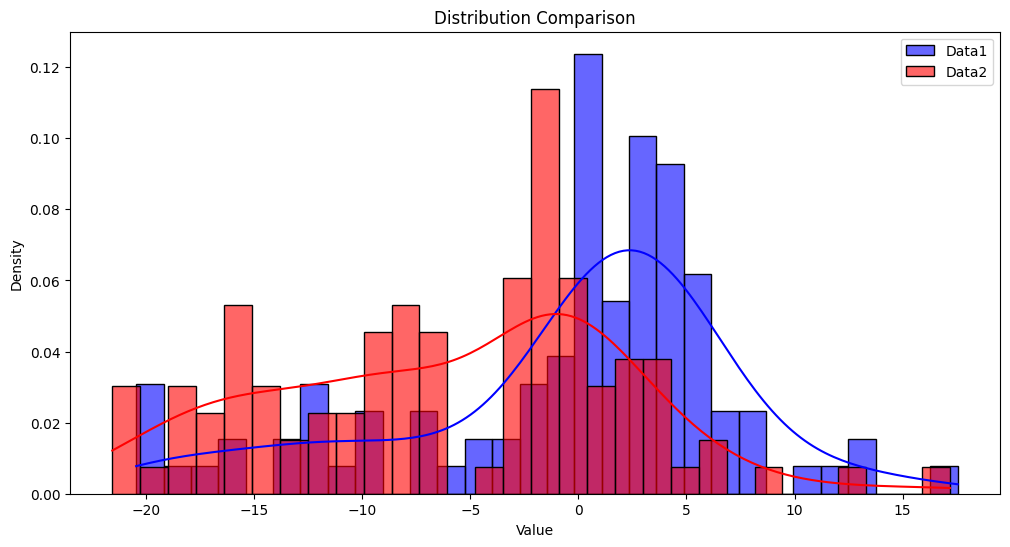

KS Statistic: 0.45098039215686275
P-value: 1.0171752271827722e-09


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns

# Generate random sample data for demonstration
np.random.seed(0)

ims = np.arange(0, 5) + 5

# Plot the distributions
plt.figure(figsize=(12, 6))

sns.histplot(normal_agg_scores, kde=True, color='blue', label='Data1', stat='density', bins=30, alpha=0.6)
sns.histplot(strange_agg_scores, kde=True, color='red', label='Data2', stat='density', bins=30, alpha=0.6)

plt.title('Distribution Comparison')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.savefig('scores.png')
plt.show()

# Perform KS test
ks_statistic, p_value = ks_2samp(normal_agg_scores, strange_agg_scores)


print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

In [13]:
import numpy as np
true_classes = np.array([0] * 102 + [1] * 102)


In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_classes, strange_agg_scores + normal_agg_scores)

0.7220299884659745

In [14]:
preds = normal_agg_scores + strange_agg_scores
bin_preds = np.array(preds) < 0

In [ ]:
digital_preds = []

for f in facts:
    digital_preds.append(int(get_digital(f) > 0))


In [16]:
normal = """no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
hal
hal
no hal
hal
no hal
hal
no hal
hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
hal
no hal
no hal
no hal
maybe hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
hal
hal
hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
hal
no hal
hal
no hal
no hal
no hal
hal
no hal
hal"""

hals = []

for a in normal.split('\n'):
    # if a == 'hal':
    hals.append(int(a == 'hal'))
# hal = []

In [17]:
st = """hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
no hal
hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
hal
hal
no hal
no hal
no hal
hal
hal
no hal
no hal
no hal
hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
no hal
hal
no hal
no hal
hal
no hal
hal
no hal
no hal
hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
no hal
hal
hal
hal
hal
no hal
hal
no hal
hal
hal
no hal
hal
no hal
hal
hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
no hal
hal
no hal
hal
no hal
no hal
hal
no hal
hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
hal
no hal
no hal
no hal
no hal
no hal
no hal
hal"""

for a in st.split('\n'):
    # if a == 'hal':
    hals.append(int(a == 'hal'))
# hal = []

In [28]:
bin_dig = (np.array(dig) > 0).astype(int)

In [34]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(bin_preds, hals)

0.28232897584817607

In [43]:
import numpy as np
from scipy.stats import chi2_contingency

a = sum([1 if (b == 0 and h == 0)  else 0 for b, h in zip(bin_preds, hals) ]) 
b = sum([1 if (b == 0 and h == 1)  else 0 for b, h in zip(bin_preds, hals) ])
c = sum([1 if (b == 1 and h == 0)  else 0 for b, h in zip(bin_preds, hals) ])
d = sum([1 if (b == 1 and h == 1)  else 0 for b, h in zip(bin_preds, hals) ])


contingency_table = np.array([[a, b],
                              [c, d]])

chi2, p, _, _ = chi2_contingency(contingency_table)

n = contingency_table.sum()
phi_coefficient = np.sqrt(chi2 / n)

print(f"Phi Coefficient: {phi_coefficient}")
print(f"p-value: {p}")

alpha = 0.05
if p < alpha:
    print("The association between the variables is statistically significant.")
else:
    print("The association between the variables is not statistically significant.")


Phi Coefficient: 0.16872047649969282
p-value: 0.01596081198198851
The association between the variables is statistically significant.


In [8]:
p_hn = [0, 0]
p_hs = [0, 0]

for s, h in zip(true_classes, hals):
    if s:
        p_hs[1] += 1
        if h:
            p_hs[0] += 1
    else:
        p_hn[1] += 1
        if h:
            p_hn[0] += 1

In [9]:
for p, name in zip([p_hn, p_hs], ["hall|normal", "hall|strange"]):
    print(f"P({name})={p[0]/p[1]}")

P(hall|normal)=0.17647058823529413
P(hall|strange)=0.3333333333333333


In [22]:
dig = norm + strange

In [17]:
p_dn = [0, 0]
p_ds = [0, 0]

for s, h in zip(true_classes, dig):
    if s:
        p_ds[1] += 1
        if h:
            p_ds[0] += 1
    else:
        p_dn[1] += 1
        if h:
            p_dn[0] += 1

In [19]:
for p, name in zip([p_dn, p_ds], ["dig|normal", "dig|strange"]):
    print(f"P({name})={p[0]/p[1]}")

P(dig|normal)=0.35294117647058826
P(dig|strange)=0.6568627450980392


In [20]:
p_hdn = [0, 0]
p_hds = [0, 0]

for s, h, d in zip(true_classes, hals, dig):
    if s:
        p_hds[1] += 1
        if h and d:
            p_hds[0] += 1
    else:
        p_hdn[1] += 1
        if h and d:
            p_hdn[0] += 1

In [22]:
for p, name in zip([p_hdn, p_hds], ["dig & hal|normal", "dig & hal|strange"]):
    print(f"P({name})={p[0]/p[1]}")

P(dig & hal|normal)=0.049019607843137254
P(dig & hal|strange)=0.21568627450980393


In [21]:
p_sd = [0, 0] # num, den
p_sh = [0, 0]
p_shd = [0, 0]
p_dh = [0, 0]

for s, d, h in zip(bin_preds, digital_preds, hals):
    if h:
        p_sh[1] += 1
        p_dh[1] += 1

        if s:
            p_sh[0] += 1
        if d:
            p_dh[0] += 1

    if d:
        p_sd[1] += 1
        if s:
            p_sd[0] += 1

    if h and d:
        p_shd[1] += 1
        if s:
            p_shd[0] += 1

Вероятности

In [22]:
for p, name in zip([p_sd, p_sh, p_shd, p_dh], ["pred strange|digital", "pred strange|hal", "pred strange|hal&digital", "digital|hal"]):
    print(f"P({name})={p[0]/p[1]}")

P(pred strange|digital)=0.7572815533980582
P(pred strange|hal)=0.8076923076923077
P(pred strange|hal&digital)=0.9259259259259259
P(digital|hal)=0.5192307692307693


In [34]:
for p, name in zip([p_sd, p_sh, p_shd, p_dh], ["strange|digital", "strange|hal", "strange|hal&digital", "digital|hal"]):
    print(f"P({name})={p[0]/p[1]}")

P(strange|digital)=0.6504854368932039
P(strange|hal)=0.6538461538461539
P(strange|hal&digital)=0.8148148148148148
P(digital|hal)=0.5192307692307693


In [38]:
[p_sd, p_sh, p_shd, p_dh]

[[67, 103], [34, 52], [22, 27], [27, 52]]

Корреляции

In [37]:
from scipy.stats import pearsonr   

print(pearsonr(true_classes, digital_preds), pearsonr(true_classes, hals))
# np.corrcoef(bin_preds, hals)

PearsonRResult(statistic=0.3039361756766328, pvalue=9.89739815343282e-06) PearsonRResult(statistic=0.1799685082663391, pvalue=0.010002733618734678)


##### explore

In [18]:
import pandas as pd

df = pd.DataFrame(data)

df['normal_score'] = normal_agg_scores
df['strange_score'] = strange_agg_scores

In [19]:
df[df['normal_score'] < 0]

,normal,strange,normal_score,strange_score
2,[The image depicts a large sailing ship with m...,[This is a digitally created image of a ship s...,-11.781667,4.465455
4,[Santa Claus is riding a team of reindeer thro...,"[Santa Claus is riding a horse-drawn sleigh., ...",-2.331000,-17.468333
8,"[The tank is surrounded by water., The image d...","[The tank is pink., This is a digitally altere...",-9.929000,-0.531818
11,"[This is a relief of a pharaoh, possibly Rames...",[This image depicts an ancient Egyptian scene ...,-18.880000,-14.990000
19,"[The house is in the middle of a field., This ...",[This image depicts a dilapidated house in a d...,-2.802667,-6.316429
21,[This is a painting of a woman looking at her ...,[The girl is looking at her reflection in the ...,-5.798333,-1.660000
22,"[The bird is perched on a tree stump., This is...","[The bird has a red crest., This is a bird wit...",-6.986000,-6.333333
25,"[The child is vacuuming the floor., This is a ...",[The man is using a vacuum cleaner on the beac...,-1.151667,-6.706364
28,[The woman is wearing a pink shirt and a brown...,"[The woman is pregnant., This is a black and w...",-6.822727,-0.620769
31,[This is a black and white photo of a woman re...,[This is a black and white photo of a woman us...,-3.927000,-6.299286


In [21]:
input = df['normal'].loc[4]

In [22]:
pairs = list(itertools.combinations(input, r=2))

formatted_pairs_1 = [(pair[0], pair[1]) for pair in pairs]
formatted_pairs_2 = [(pair[1], pair[0]) for pair in pairs]

score_1, score_2 = get_custom_scores(input)

for (pair_0, pair_1), s in zip(formatted_pairs_1, score_1):
    print(pair_0, pair_1, weighted_agg(s))

Santa Claus is riding a team of reindeer through a snowy forest. The reindeer are pulling Santa Claus through a snowy forest. 3.775
Santa Claus is riding a team of reindeer through a snowy forest. This image depicts a classic holiday scene with Santa Claus and his reindeer. 9.515
Santa Claus is riding a team of reindeer through a snowy forest. This is a digital artwork of Santa Claus riding reindeer through a snowy forest. -0.4600000000000002
Santa Claus is riding a team of reindeer through a snowy forest. The image features a jovial Santa Claus riding a team of reindeer through a snowy forest. 6.164999999999999
The reindeer are pulling Santa Claus through a snowy forest. This image depicts a classic holiday scene with Santa Claus and his reindeer. 10.684999999999999
The reindeer are pulling Santa Claus through a snowy forest. This is a digital artwork of Santa Claus riding reindeer through a snowy forest. -2.3099999999999996
The reindeer are pulling Santa Claus through a snowy forest.

In [23]:
for (pair_0, pair_1), s in zip(formatted_pairs_2, score_2):
    print(pair_0, pair_1, weighted_agg(s))

The reindeer are pulling Santa Claus through a snowy forest. Santa Claus is riding a team of reindeer through a snowy forest. -4.6049999999999995
This image depicts a classic holiday scene with Santa Claus and his reindeer. Santa Claus is riding a team of reindeer through a snowy forest. -5.035
This is a digital artwork of Santa Claus riding reindeer through a snowy forest. Santa Claus is riding a team of reindeer through a snowy forest. 8.47
The image features a jovial Santa Claus riding a team of reindeer through a snowy forest. Santa Claus is riding a team of reindeer through a snowy forest. 8.575
This image depicts a classic holiday scene with Santa Claus and his reindeer. The reindeer are pulling Santa Claus through a snowy forest. 3.355
This is a digital artwork of Santa Claus riding reindeer through a snowy forest. The reindeer are pulling Santa Claus through a snowy forest. 5.27
The image features a jovial Santa Claus riding a team of reindeer through a snowy forest. The reinde

### Grid search

In [30]:
from tqdm import tqdm

best_acc = 0

for ent_w in tqdm(np.arange(-2, 3, 1)):
    for cont_w in np.arange(-5, 3, 1):
        for neutral_w in np.arange(-5, 3, 1):
            if ent_w == 0 and cont_w == 0 and neutral_w == 0:
                continue
            normal_agg_scores = []
            strange_agg_scores = []

            for normal_score, strange_score in zip(normal_scores, strange_scores):
                normal_agg_scores.append(aggregation(*normal_score, ent_w=ent_w, cont_w=cont_w, neutral_w=neutral_w)[0])
                strange_agg_scores.append(aggregation(*strange_score, ent_w=ent_w, cont_w=cont_w, neutral_w=neutral_w)[0])

            for thr in np.arange(min(normal_agg_scores + strange_agg_scores),
                                 max(normal_agg_scores + strange_agg_scores), 
                                 0.1):

                our_outputs = [el < thr for el in normal_agg_scores + strange_agg_scores]
                acc = accuracy_score(true_classes, our_outputs)
                if acc > best_acc:
                    best_acc = acc
                    best_ent_w = ent_w
                    best_cont_w = cont_w
                    best_neutral_w = neutral_w
                    print(f"New best acc={round(acc * 100, 2)}% on {thr=} {ent_w=}, {cont_w=}, {neutral_w=}")


  0%|          | 0/5 [00:00<?, ?it/s]

New best acc=50.0% on thr=-7.109999999999999 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=50.49% on thr=-7.01 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=50.98% on thr=-5.710000000000004 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=51.47% on thr=-5.4100000000000055 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=51.96% on thr=-5.1100000000000065 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=52.45% on thr=-4.310000000000009 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=52.94% on thr=-4.21000000000001 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=53.43% on thr=-4.11000000000001 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=54.9% on thr=-3.610000000000012 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=55.88% on thr=-3.510000000000012 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=56.86% on thr=-3.4100000000000126 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=57.84% on thr=-3.310000000000013 ent_w=-2, cont_w=-5, neutral_w=-5
New best acc=58.33% on thr=-3.2100000000000133 ent_w=-

 40%|████      | 2/5 [00:34<00:52, 17.34s/it]

New best acc=71.08% on thr=1.6133333333336033 ent_w=0, cont_w=-4, neutral_w=-2


 60%|██████    | 3/5 [00:52<00:35, 17.75s/it]

New best acc=71.57% on thr=0.8383333333337575 ent_w=1, cont_w=-5, neutral_w=-2
New best acc=72.06% on thr=1.3383333333337646 ent_w=1, cont_w=-5, neutral_w=-2
New best acc=72.55% on thr=0.6316666666669626 ent_w=1, cont_w=-3, neutral_w=-1


100%|██████████| 5/5 [01:35<00:00, 19.14s/it]
